Joao Quinta

## TP 6

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd

df = pd.read_csv("eur_usd_20120101_20120301.txt", sep="	", names=["Timestamp", "BID", "ASK"])
df = df[df["Timestamp"] > 1262304000]

### EX 1: TWAP Algorithm

In [24]:
# takes 10 times 20 random samples from df
starting_timestamps = df["Timestamp"].sample(n=20, random_state=42).sort_index()
starting_timestamps = np.array(starting_timestamps).astype(int).tolist()

# function that buys every 15 minutes
def time_weighted_average_price(data, start_timestamp, intervals=12, total_shares=12000000):
    shares_per_interval = total_shares // intervals
    purchase_prices = []
    
    for _ in range(intervals):
        # take closest timestamp to start_timestamp and takes its ASK price
        price = data[data["Timestamp"] <= start_timestamp].iloc[-1][-1] * shares_per_interval
        purchase_prices.append(price)
        start_timestamp += 900
    return purchase_prices

# execute Time Weighted Average Price (TWAP) algorithm on each sample
results = [time_weighted_average_price(df, st_time) for st_time in starting_timestamps]

# buying 12 million shares at each starting time
total_purchase_prices = []
for st in starting_timestamps:
    # take closest timestamp to starting_time and takes its ASK price
    price = df[df["Timestamp"] <= st].iloc[-1][-1] * 12000000
    total_purchase_prices.append(price)        

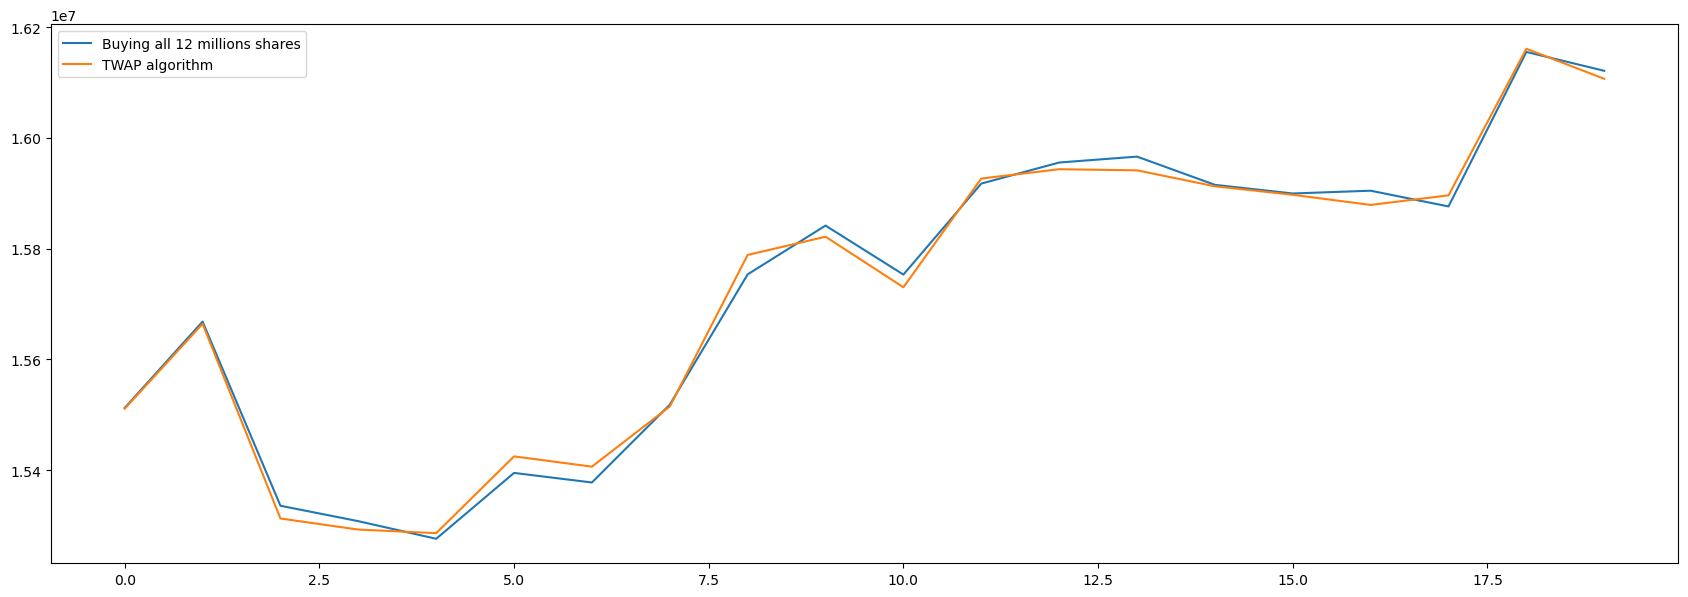

Mean gain: 1662.4999999997206 	Std: 18529.360721568493


In [25]:
# comparaison of buying all 12 millions shares at each starting time and TWAP algorithm
plt.figure(figsize=(21,7))
plt.plot(range(20), all_buy, label="Buying all 12 millions shares")
plt.plot(range(20), np.sum(res, axis=1), label="TWAP algorithm")
plt.legend()
plt.show()

print("Mean gain:", np.mean(all_buy - np.sum(res, axis=1)), "\tStd:" , np.std(all_buy - np.sum(res, axis=1)))

TWAP doesn't offer too many chances of getting benefits.  
On the chose 20 timestamps, we gained 1660.  
With 12 million buys and STD 18529, seems to be a bad tactic.  

### EX 2: VWAP Algorithm

In [27]:
# function that buys every 15 minutes
def volume_weighted_average_price(data, start_timestamp, histogram, bin_edges, intervals=12, total_shares=12000000):
    purchase_prices = []
    
    # find the bin of the starting time
    bin_index = np.argmin(np.abs(np.array(bin_edges) % 86400 - (start_timestamp % 86400)))
    histogram_sum = np.sum(histogram[bin_index:bin_index+intervals])
    
    # buy shares proportionally to the histogram
    for i in range(intervals):
        if bin_index < len(histogram):
            allocated_shares = total_shares * histogram[bin_index] / histogram_sum
            # take closest timestamp to start_timestamp and takes its ASK price
            price = data[data["Timestamp"] <= start_timestamp].iloc[-1][-1] * allocated_shares
            purchase_prices.append(price)
            start_timestamp += 900
            bin_index += 1
        else:
            break
    return purchase_prices
    return purchase_prices

timestamps_modulo = df["Timestamp"] % 86400
num_bins = 4 * 24

histogram, bin_edges = np.histogram(timestamps_modulo, num_bins)
bin_edges = bin_edges[1:]

# execute Volume Weighted Average Price (VWAP) algorithm on each sample
results_vwap = [volume_weighted_average_price(df, st_time, histogram, bin_edges) for st_time in starting_timestamps]

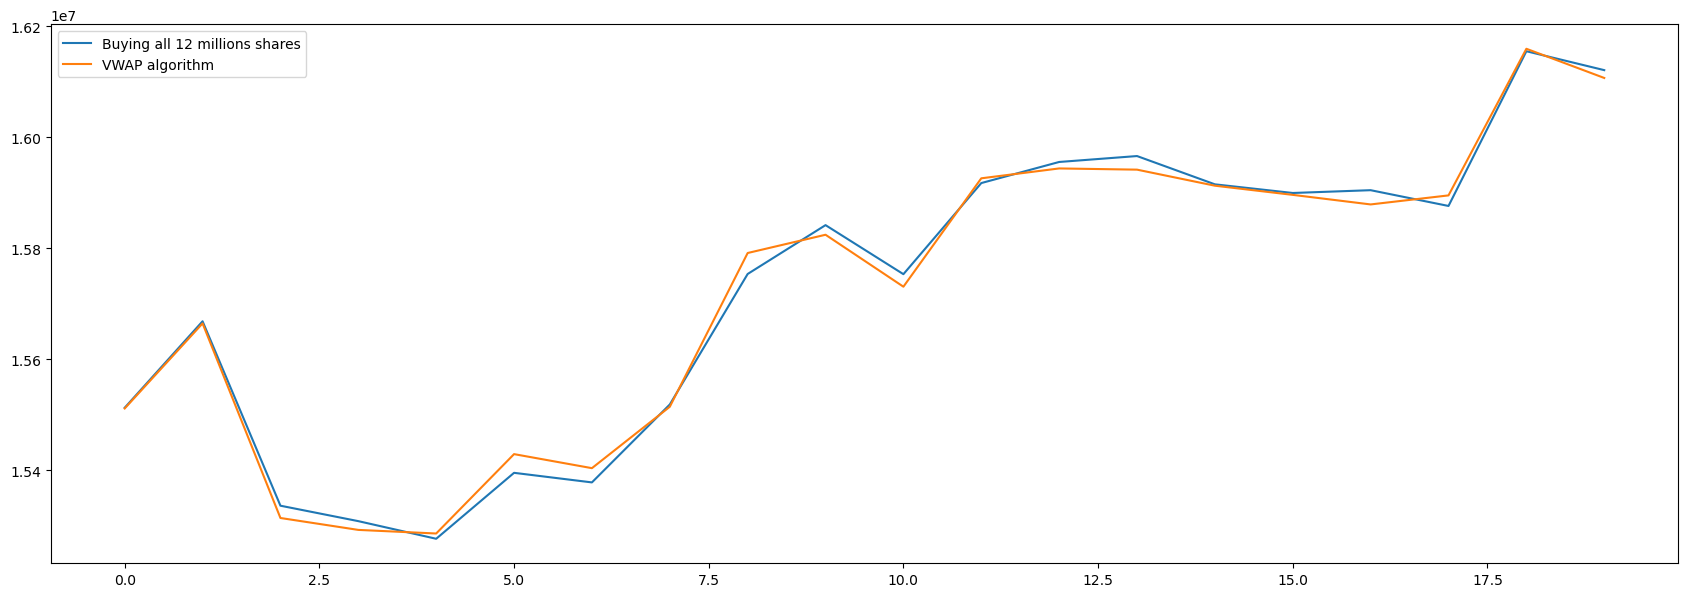

Mean gain: 1504.6643395562655 	Std: 18607.884555324945


In [28]:
# comparaison of buying all 12 millions shares at each starting time and VWAP algorithm
plt.figure(figsize=(21,7))
plt.plot(range(20), all_buy, label="Buying all 12 millions shares")
plt.plot(range(20), np.sum(res_vwap, axis=1), label="VWAP algorithm")
plt.legend()
plt.show()

print("Mean gain:", np.mean(all_buy - np.sum(res_vwap, axis=1)), "\tStd:" , np.std(all_buy - np.sum(res_vwap, axis=1)))

Just like in TWAP, it isn't much better. 

### EX 3: Algorithm based on price evolution

In [29]:
ask = df["ASK"].to_numpy()

In [30]:
def directional_changes(time_series, start_idx, threshold, init_direction='up'):
    dc_results = []
    current_direction = init_direction
    extremum = 0
    for i in range(start_idx, time_series.size):
        if current_direction == 'up':
            if time_series[i] < time_series[extremum]:
                extremum = i
            elif (time_series[i] - time_series[extremum]) / time_series[extremum] > threshold:
                dc_results.append(np.array([extremum, i, 1]))
                current_direction = 'down'
                extremum = i
        else:
            if time_series[i] > time_series[extremum]:
                extremum = i
            elif (time_series[extremum] - time_series[i]) / time_series[extremum] > threshold:
                dc_results.append(np.array([extremum, i, -1]))
                current_direction = 'up'
                extremum = i
    return np.array(dc_results)

def directional_changes_purchase(time_series, threshold, data_frame, start_timestamp, intervals=12, total_shares=12000000, init_direction='up', three_hours=False):
    shares_per_interval = total_shares // intervals
    purchase_prices = []
    starting_idx = data_frame[data_frame["Timestamp"] == start_timestamp].iloc[0].name
    
    dc_results = directional_changes(time_series, starting_idx, threshold, init_direction)
    num_dc = np.sum(dc_results[:, 2] == -1)
    
    if three_hours:
        elapsed_time = dc_results[-1, 1] - dc_results[0, 0]
        while num_dc < intervals and elapsed_time >= 10800:
            threshold -= 0.001
            dc_results = directional_changes(time_series, starting_idx, threshold, init_direction)
            num_dc = np.sum(dc_results[:, 2] == -1)
            elapsed_time = dc_results[-1, 1] - dc_results[0, 0]
        
        for k in range(intervals):
            tmp_price = time_series[dc_results[k, 1]] * shares_per_interval
            purchase_prices.append(tmp_price)
        print("Threshold=", threshold)
    else:
        while num_dc < intervals:
            threshold -= 0.001
            dc_results = directional_changes(time_series, starting_idx, threshold, init_direction)
            num_dc = np.sum(dc_results[:, 2] == -1)
        
        for k in range(intervals):
            tmp_price = time_series[dc_results[k, 1]] * shares_per_interval
            purchase_prices.append(tmp_price)
        print("Threshold=", threshold)

    return purchase_prices

In [31]:
delta = 0.01
dc_res = [dc_buy(ask, delta, df, st_time, slices=12, nbShares=12000000, initial_direction='up') for st_time in starting_times]

Delta= 0.009000000000000001
Delta= 0.008
Delta= 0.008
Delta= 0.008
Delta= 0.008
Delta= 0.008
Delta= 0.008
Delta= 0.008
Delta= 0.005
Delta= 0.005
Delta= 0.005
Delta= 0.005
Delta= 0.004
Delta= 0.004
Delta= 0.004
Delta= 0.004
Delta= 0.002
Delta= 0.002
Delta= 0.002
Delta= 0.002


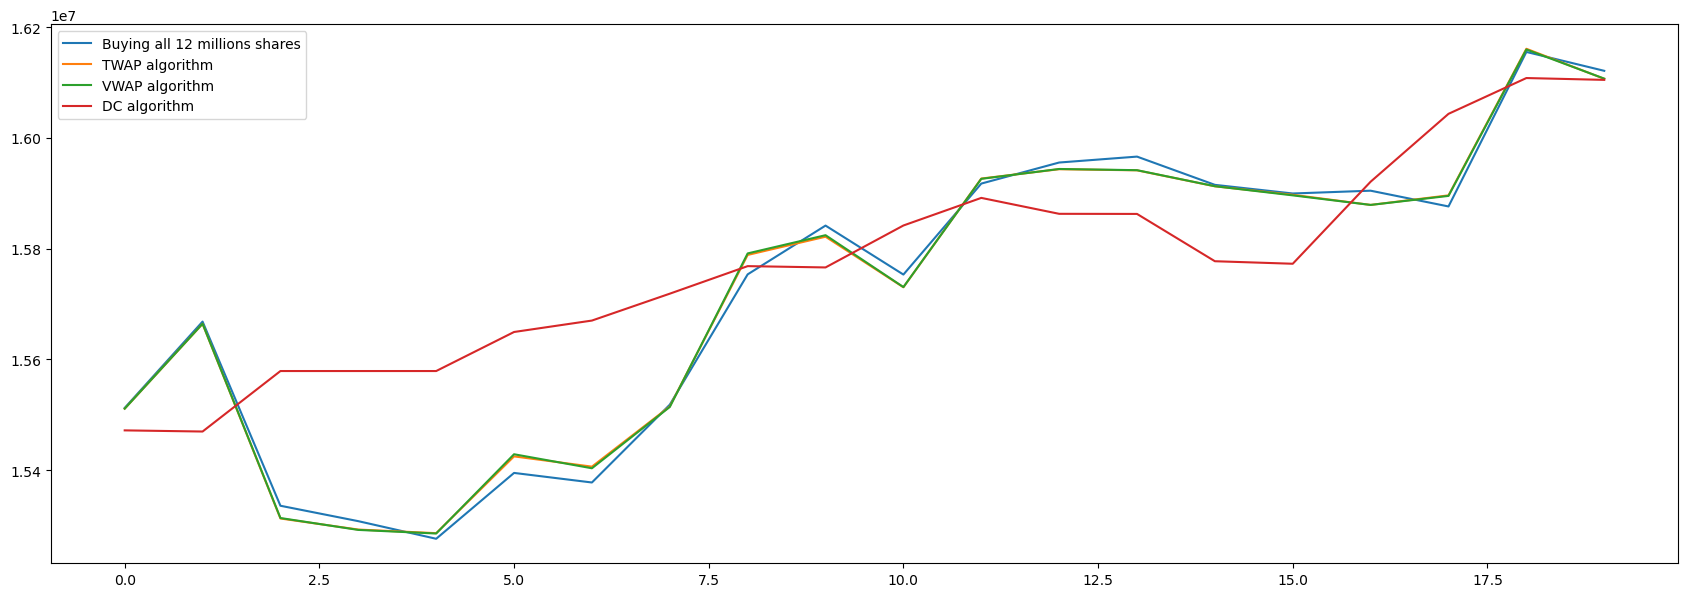

Mean gain: -49338.00000000028 	Std: 159190.45711348407


In [32]:
plt.figure(figsize=(21,7))
plt.plot(range(20), all_buy, label="Buying all 12 millions shares")
plt.plot(range(20), np.sum(res, axis=1), label="TWAP algorithm")
plt.plot(range(20), np.sum(res_vwap, axis=1), label="VWAP algorithm")
plt.plot(range(20), np.sum(dc_res, axis=1), label="DC algorithm")
plt.legend()
plt.show()
print("Mean gain:", np.mean(all_buy - np.sum(dc_res, axis=1)), "\tStd:" , np.std(all_buy - np.sum(dc_res, axis=1)))

We still have a large std.  
It would probably be best to make our desicions based on $\delta$.  
However, it looks like TWAP and VWAP manage to reduce our risk.  

In [33]:
delta = 0.01
dc_3hours_res = [dc_buy(ask, delta, df, st_time, slices=12, nbShares=12000000, initial_direction='up', threeHours=True) for st_time in starting_times]

Delta= 0.009000000000000001
Delta= 0.008
Delta= 0.008
Delta= 0.008
Delta= 0.008
Delta= 0.008
Delta= 0.008
Delta= 0.008
Delta= 0.005
Delta= 0.005
Delta= 0.005
Delta= 0.005
Delta= 0.004
Delta= 0.004
Delta= 0.004
Delta= 0.004
Delta= 0.002
Delta= 0.002
Delta= 0.002
Delta= 0.002


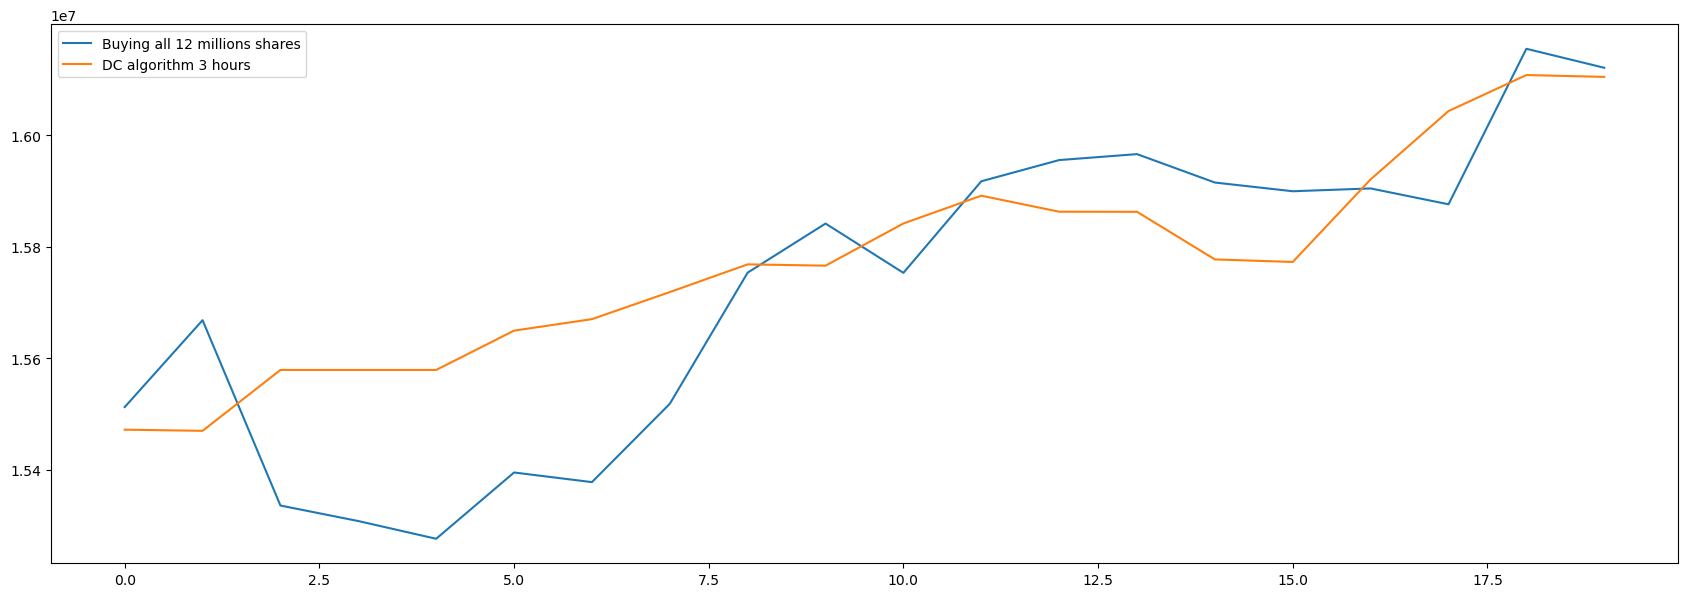

In [34]:
plt.figure(figsize=(21,7))
plt.plot(range(20), all_buy, label="Buying all 12 millions shares")
plt.plot(range(20), np.sum(dc_3hours_res, axis=1), label="DC algorithm 3 hours")
plt.legend()
plt.show()